In [1]:
import torch
from langchain.prompts import PromptTemplate
import gradio as gr
from transformers import pipeline
from transformers.pipelines.audio_utils import ffmpeg_read
from langchain.chains import LLMChain
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain
import warnings
warnings.filterwarnings("ignore")
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os
import textwrap
import langchain
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import LlamaTokenizer, LlamaForCausalLM, pipeline
from InstructorEmbedding import INSTRUCTOR
langchain.verbose = True
from huggingface_hub import login
import os
import pandas as pd
from datetime import datetime
import time
print(os.environ['PATH'])



####################
#Setting Up Whisper
####################

MODEL_NAME = "distil-whisper/distil-large-v2"
BATCH_SIZE = 8
FILE_LIMIT_MB = 1000
#TODO:FIX Add functionality to load in CPU if only 1 GPU available
device = 0 if torch.cuda.is_available() else "cpu"
#device = "cpu"

pipe = pipeline(
    task="automatic-speech-recognition",
    model=MODEL_NAME,
    chunk_length_s=30,
    device=device,
)


def transcribe(inputs, task):
    if inputs is None:
        raise gr.Error("No audio file submitted! Please upload or record an audio file before submitting your request.")
    text = pipe(inputs, 
                batch_size=BATCH_SIZE, 
                generate_kwargs={"task": task}, 
                return_timestamps=True)["text"]

    return text

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/usr/lib/jvm/java-8-openjdk-amd64/bin:/home/cdsw/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/conda/bin:/usr/lib/hadoop/bin:/usr/lib/hadoop-hdfs/bin


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
import os
import pandas as pd
from datetime import datetime
from pydub.utils import mediainfo

def get_audio_length(file_path):
    # Get audio file information
    info = mediainfo(file_path)
    # Convert duration from milliseconds to seconds and format it
    minutes, seconds = divmod(float(info['duration']), 60)
    return f"{int(minutes):02d}m {int(seconds):02d}s"


def process_audio_files(audio_folder, text_folder, task):
    log_data = pd.DataFrame(columns=['audio_file', 'text_file', 'audio_length', 'transcription_time(s)'])
    
    audio_files = [f for f in os.listdir(audio_folder) if os.path.isfile(os.path.join(audio_folder, f))]
    
    for audio_file in audio_files:
        audio_file_path = os.path.join(audio_folder, audio_file)
        start_time = time.time()
        text = transcribe(audio_file_path, task)
        end_time = time.time() # time.time()
        
        audio_length = get_audio_length(audio_file_path)
        transcription_time = end_time - start_time

        # minutes, seconds = divmod(transcription_time_seconds, 60)
        # transcription_time = f"{int(minutes):02d}m {int(seconds):02d}s"

        
        text_filename = os.path.splitext(audio_file)[0] + '.txt'
        text_file_path = os.path.join(text_folder, text_filename)
        with open(text_file_path, 'w') as text_file:
            text_file.write(text)
        
        
        log_row = {
            'audio_file': audio_file,
            'text_file': text_filename,
            'audio_length': audio_length,
            'transcription_time(s)': transcription_time
        }
        log_data.loc[len(log_data)] = log_row
        log_data.to_csv('distil_transcription_log.csv', index=False)
    
    return log_data


audio_folder = 'audio_data'
text_folder = 'text_data'
task = 'transcribe'

log_data = process_audio_files(audio_folder, text_folder, task)


In [4]:
import pandas as pd

# Load the CSV file into a DataFrame
df_transcription = pd.read_csv('distil_transcription_log.csv')

# Display the first few rows of the DataFrame to understand its structure
df_transcription.head()


,audio_file,text_file,audio_length,transcription_time(s)
0,10_20_2023.m4a,10_20_2023.txt,99m 35s,290.039763
1,10_06_2023.m4a,10_06_2023.txt,114m 24s,332.784128
2,09_22_2023.m4a,09_22_2023.txt,113m 15s,356.513691
3,09_29_2023.m4a,09_29_2023.txt,120m 55s,366.168539
4,10_12_2023.m4a,10_12_2023.txt,61m 41s,179.406098


In [5]:
def convert_to_seconds(time_str):
    """Convert a time string in the format 'Xm Ys' to seconds."""
    minutes, seconds = 0, 0
    if 'm' in time_str:
        minutes = int(time_str.split('m')[0].strip())
        if 's' in time_str:
            seconds = int(time_str.split('m')[1].split('s')[0].strip())
    else:
        seconds = int(time_str.split('s')[0].strip())
    
    return minutes * 60 + seconds

# Convert the 'audio_length' column to seconds
df_transcription['audio_length(s)'] = df_transcription['audio_length'].apply(convert_to_seconds)

# Display the updated DataFrame
df_transcription.head()


,audio_file,text_file,audio_length,transcription_time(s),audio_length(s)
0,10_20_2023.m4a,10_20_2023.txt,99m 35s,290.039763,5975
1,10_06_2023.m4a,10_06_2023.txt,114m 24s,332.784128,6864
2,09_22_2023.m4a,09_22_2023.txt,113m 15s,356.513691,6795
3,09_29_2023.m4a,09_29_2023.txt,120m 55s,366.168539,7255
4,10_12_2023.m4a,10_12_2023.txt,61m 41s,179.406098,3701


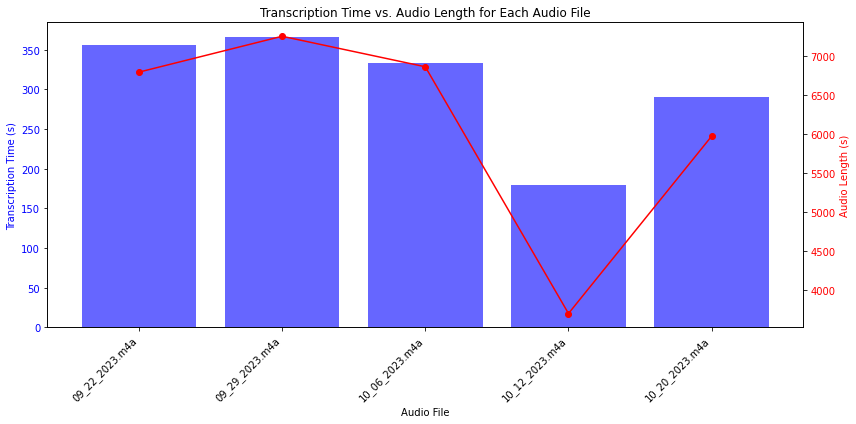

In [6]:
import matplotlib.pyplot as plt

# Sort the data based on the audio file (which seems to be named by date) for better visualization
df_transcription = df_transcription.sort_values(by='audio_file')

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Twin the axes
ax2 = ax1.twinx()

# Plot data on ax1
ax1.bar(df_transcription['audio_file'], df_transcription['transcription_time(s)'], color='b', alpha=0.6, label='Transcription Time')
ax1.set_ylabel('Transcription Time (s)', color='b')
ax1.set_xlabel('Audio File')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Transcription Time vs. Audio Length for Each Audio File')
ax1.set_xticklabels(df_transcription['audio_file'], rotation=45, ha='right')

# Plot data on ax2
ax2.plot(df_transcription['audio_file'], df_transcription['audio_length(s)'], color='r', marker='o', label='Audio Length')
ax2.set_ylabel('Audio Length (s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.tight_layout()
plt.show()


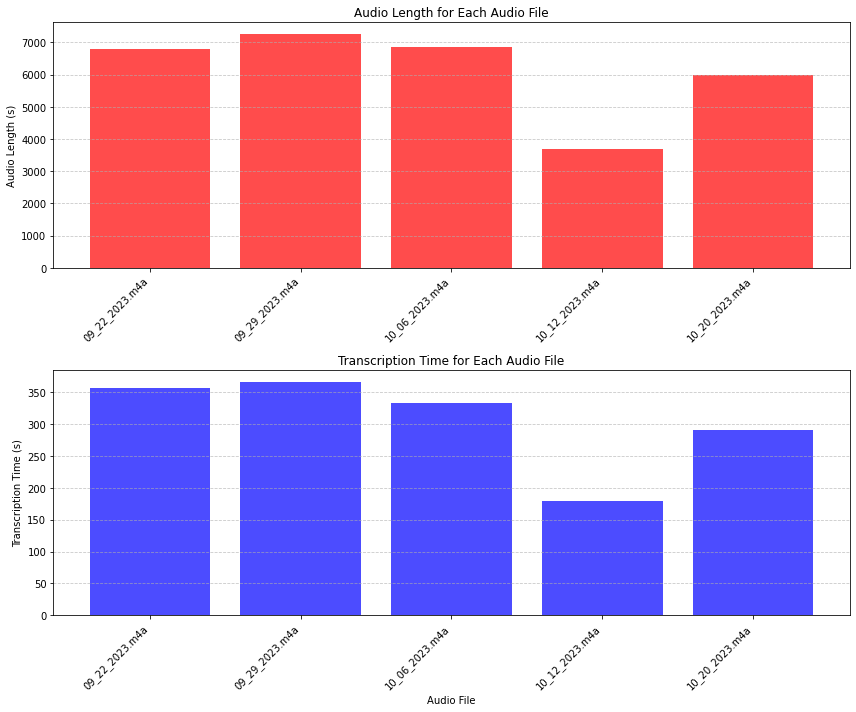

In [7]:
# Plotting audio length against each audio file
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot for Audio Length
ax1.bar(df_transcription['audio_file'], df_transcription['audio_length(s)'], color='r', alpha=0.7)
ax1.set_ylabel('Audio Length (s)')
ax1.set_title('Audio Length for Each Audio File')
ax1.set_xticklabels(df_transcription['audio_file'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Transcription Time
ax2.bar(df_transcription['audio_file'], df_transcription['transcription_time(s)'], color='b', alpha=0.7)
ax2.set_ylabel('Transcription Time (s)')
ax2.set_xlabel('Audio File')
ax2.set_title('Transcription Time for Each Audio File')
ax2.set_xticklabels(df_transcription['audio_file'], rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


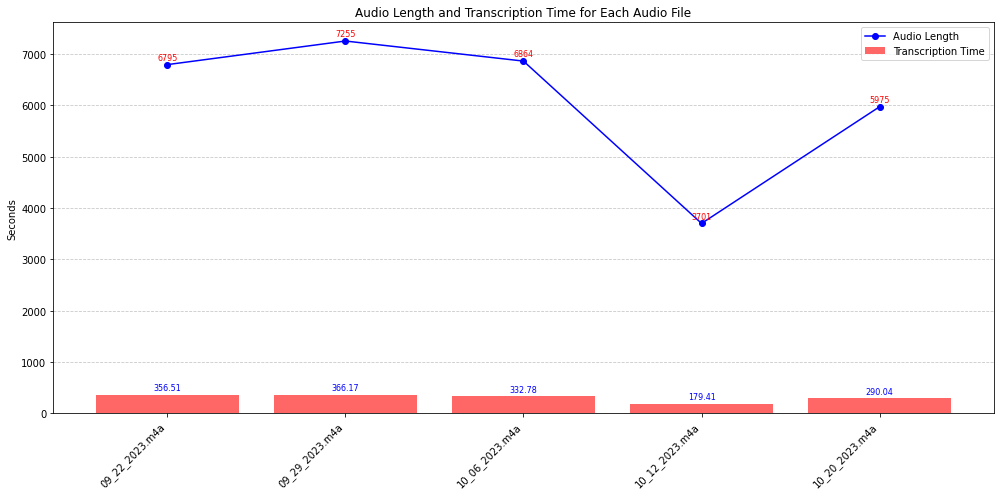

In [8]:
# Plotting audio length as a line and transcription time as bars with labels
fig, ax = plt.subplots(figsize=(14, 7))

# Bar plot for Transcription Time
bars = ax.bar(df_transcription['audio_file'], df_transcription['transcription_time(s)'], color='r', alpha=0.6, label='Transcription Time')

# Line plot for Audio Length
line, = ax.plot(df_transcription['audio_file'], df_transcription['audio_length(s)'], color='b', marker='o', label='Audio Length')

# Adding labels to bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 50, round(yval, 2), ha='center', va='bottom', color='b', fontsize=8)

# Adding labels to line graph points
for i, txt in enumerate(df_transcription['audio_length(s)']):
    ax.text(i, txt + 50, txt, ha='center', va='bottom', color='r', fontsize=8)

ax.set_ylabel('Seconds')
ax.set_title('Audio Length and Transcription Time for Each Audio File')
ax.set_xticklabels(df_transcription['audio_file'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
